**VGG **– это свёрточная нейронная сеть с глубиной 19 слоев. Она была построена и обучена **К. Симоняном** и **А. Зиссерманом** в Оксфордском университете в **2014** году. Вся информация об этом есть в статье **[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://)**, опубликованной в **2015** году. Сеть **VGG-19** обучена с использованием более одного миллиона изображений из базы данных **ImageNet**. Она обучалась на цветных изображениях размером **224x224** пикселей. Естественно, вы можете импортировать модель **ImageNet** с уже обученными весами. Эта предварительно обученная сеть может классифицировать до тысячи объектов. В этом туториале мы избавимся от верхней части, используемой для классификации, и добавим наши собственные дополнительные слои, чтобы её можно было использовать для нейронного переноса стиля. Вот официальная визуализация сети из научной работы:

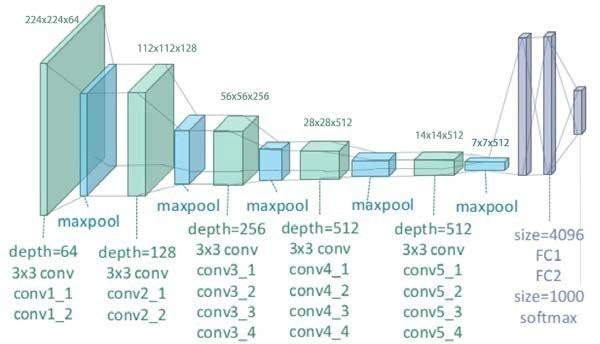

In [ ]:
import tensorflow as tf

content_path = tf.keras.utils.get_file('photo-1563306406-e66174fa3787',
                                       'https://www.strill.it/wp-content/uploads/2014/09/al-pacino.jpg')

style_path = tf.keras.utils.get_file('Andy-Warhol--Marilyn-Monroe-Hot-Pink-1967-Andy-Warhol-Poster.jpg',
                                     'https://pbs.twimg.com/profile_images/845538951654002689/D0Ui2C3M_400x400.jpg')


In [ ]:
def img_scaler(image, max_dim = 256):
  # Приводит тензор к новому типу
  original_shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  # Создает константу масштаба для изображения
  scale_ratio = 4 * max_dim / max(original_shape)
  # Приводит тензор к новому типу
  new_shape = tf.cast(original_shape * scale_ratio, tf.int32)
  # Изменяет размер изображения на основе константы масштабирования, сгенерированной выше.
  return tf.image.resize(image, new_shape)

In [ ]:
def load_img(path_to_img):
  # Читает и выводит все содержимое входного имени файла
  img = tf.io.read_file(path_to_img)
  # Определите, является ли изображение BMP, GIF, JPEG или PNG, и
  # выполняет соответствующую операцию для преобразования ввода
  # строка байтов в тензор типа dtype
  img = tf.image.decode_image(img, channels=3)
  # Преобразуйте изображение в dtype, масштабируя (MinMax Normalization) его значения, если это необходимо
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Масштабируйте изображение с помощью созданной нами пользовательской функции
  img = img_scaler(img)
  # Добавляет четвертое измерение к тензору, потому что
  # для модели требуется 4-мерный тензор
  return img[tf.newaxis, :]

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.title('Изображение содержимого')
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.title('Стиль изображения')

plt.show()

In [ ]:
# Создает предварительно обученную модель VGG, которая принимает входные данные и возвращает список промежуточных выходных значений.
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Загрузите нашу модель. Загрузите предварительно обученный VGG, обученный на данных imagenet
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
def gram_matrix(input_tensor):
  # Тензорное сжатие по заданным индексам и внешнему произведению
  # Умножение матриц
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  # Сохраните форму входного тензора
  input_shape = tf.shape(input_tensor)
  # Приводит тензор к новому типу
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  # Разделить результат умножения матриц на num_locations
  return result/(num_locations)

In [ ]:
# Мы будем использовать слой block5 conv2 для контента
content_layers = ['block5_conv2']
# Мы будем использовать слои conv1 из каждого блока для стиля
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    # Главный
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False

    # Используется в качестве ключей при создании словаря
    self.style_layers = style_layers
    self.content_layers = content_layers
    # self.num_style_layers = длина (style_layers)


  def call(self, inputs):
    # Обработать ввод изображения
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Загрузите предварительно обработанное изображение в модель VGG19.
    outputs = self.vgg(preprocessed_input)
    # Отдельный вывод стиля и контента
    style_outputs, content_outputs = (outputs[:len(self.style_layers)],
                                      outputs[len(self.style_layers):])
    # Вывод стиля обработки перед созданием словаря
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]


    # Создайте два словаря для вывода содержимого и стиля.
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

extractor = StyleContentModel(style_layers, content_layers)
# Установите целевые значения стиля и содержания:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
# Создайте оптимизатор. В документе рекомендуется LBFGS, но Адам тоже работает нормально:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

# Чтобы оптимизировать это, используйте взвешенную комбинацию двух потерь, чтобы получить общую потерю:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [ ]:
total_variation_weight=500

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image,
                                clip_value_min=0.0,
                                clip_value_max=1.0))

In [ ]:
import IPython.display as display

image = tf.Variable(content_image)
epochs = 20
steps_per_epoch = 100
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  plt.imshow(image[0])
  plt.show()
  print("Поезд шаг: {}".format(step))

In [ ]:
tf.keras.preprocessing.image.save_img('stylized-image.png', image[0])